In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle

import xmeos
from xmeos import models
from xmeos import datamod

from collections import OrderedDict
CONSTS = models.CONSTS

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [3]:
props_Lange = analysis['props_Lange']
props_Ghiorso = analysis['props_Ghiorso']
datamodel = analysis['datamodel']
data = datamodel['data']

eos_mod = datamodel['eos_mod']
data['exp_constraint']


{'KT': None,
 'P': array(0),
 'T': array(1673),
 'V': array(12.803751383249672),
 'alpha': None,
 'wt': 10}

In [4]:
display(eos_mod.material_properties(props_Lange['P'],props_Lange['T']))
display(props_Lange)

OrderedDict([('P', 0),
             ('T', 1673),
             ('V', 11.790827550351612),
             ('KT', 10.487930644160759),
             ('KS', 10.871889894046701),
             ('Cv', array([ 4.25430641])),
             ('therm_exp', 0.00010195032601739767),
             ('gamma', 0.21464005351665716)])

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

In [15]:
Tfoot_grid = np.arange(2000,9001,1000)
Pgrid = np.arange(0,550.1,1)
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid, Pgrid)

<IPython.core.display.Javascript object>


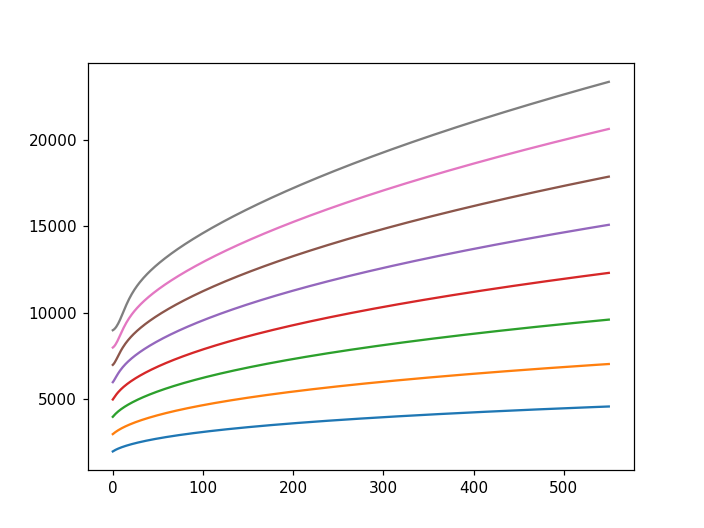

In [16]:
plt.figure()
for Tad in Tad_grid:
    plt.plot(Pgrid, Tad, '-')
    

<IPython.core.display.Javascript object>


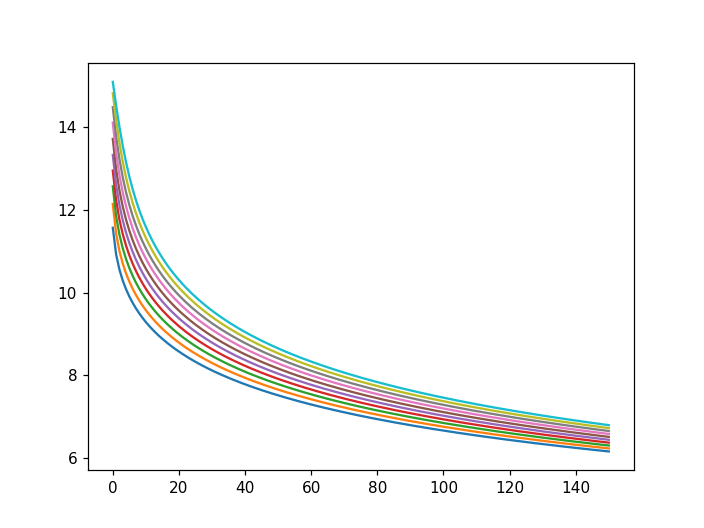

In [7]:
plt.figure()
for Vad in Vad_grid:
    plt.plot(Pgrid, Vad, '-')

In [8]:
cmap = plt.get_cmap('RdBu')
plt.imshow(corr, cmap=cmap)
plt.clim(-1,1)
plt.colorbar()

NameError: name 'corr' is not defined

In [9]:
eos_mod = datamodel['eos_mod']
tbl = datamodel['data']['table']
Tlbl = data['T_labels']
delT = Tlbl[1]-Tlbl[0]


cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
V0 = params['V0']

Vmod = V0*np.linspace(.4,1.1,1001)


plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(Tlbl)



NameError: name 'params' is not defined

In [ ]:
plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)